In [1]:
!pip install catboost

Looking in indexes: https://nexus.isb/repository/pypiorg-pypi-proxy/simple, https://nexus.isb/repository/deml-prod-pypi-hosted/simple


In [2]:
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from catboost import CatBoostClassifier
import sklearn.model_selection
import sklearn.preprocessing
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt

from itertools import product

### === Готовим данные для модели ===

In [3]:
df = pd.read_csv('iar_hse_data.csv')

In [4]:
df.head()

,product_grp,requested_sum,used_score,personal_income,es_1,es_2,es_3,cnt_all_apps_last7days,cnt_all_apps_last30days,cnt_all_apps_last90days,cnt_refused_apps_last7days,cnt_refused_apps_last30days,cnt_refused_apps_last90days,online_flg,bureau_hist_due,appnumberofappslm,count_bureau_credits_less_730_days,client_segment,target,cnt_open_agr_7,cnt_open_agr_30,cnt_open_agr_90
0,cash,55000,687,38000,5,5,4,6,6,7,0,0,0,1,4817,-1,-1,BANK,0,0,0,0
1,cash,218771,666,95000,5,5,3,3,3,3,0,0,0,1,3973,-1,-1,BANK,0,0,0,0
2,cash,106233,671,50000,5,5,3,10,10,10,4,4,4,1,3698,-1,-1,BANK,0,0,0,0
3,cash,130671,678,30000,5,5,3,6,6,6,0,0,0,1,4374,-1,-1,BANK,1,0,0,0
4,cash,190000,633,35000,5,1,2,4,4,4,1,1,1,1,5729,-1,-1,BANK,1,0,0,0


In [5]:
y = df[['target']]
X = df.drop(columns=['target'])

In [6]:
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [7]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [8]:
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
#сплит по времени, датасет отсортирован по дате заявке
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

### === Обучение CatBoost со стандартными параметрами ===

In [9]:
model_default = CatBoostClassifier(
    cat_features=cat_features,
    auto_class_weights="Balanced",
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=100,
    random_seed=42
)

In [10]:
model_default.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

0:	learn: 0.6823399	test: 0.6825822	best: 0.6825822 (0)	total: 86.4ms	remaining: 43.1s
100:	learn: 0.5499289	test: 0.5566157	best: 0.5566157 (100)	total: 2.57s	remaining: 10.2s
200:	learn: 0.5399528	test: 0.5492753	best: 0.5492753 (200)	total: 5.1s	remaining: 7.59s
300:	learn: 0.5319584	test: 0.5435884	best: 0.5435884 (300)	total: 7.68s	remaining: 5.08s
400:	learn: 0.5255308	test: 0.5398400	best: 0.5398400 (400)	total: 10.2s	remaining: 2.51s
499:	learn: 0.5205885	test: 0.5375761	best: 0.5375761 (499)	total: 12.7s	remaining: 0us

bestTest = 0.5375760657
bestIteration = 499



In [11]:
#валидация:
y_val_pred = model_default.predict(X_val)
y_val_proba = model_default.predict_proba(X_val)[:, 1]

print("Default model:")
print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))

Default model:
ROC AUC: 0.805178353157236
Precision: 0.288122750520932
Recall: 0.7482781239750738


In [12]:
sklearn.metrics.confusion_matrix(y_val, y_val_pred)

array([[27628, 11274],
       [ 1535,  4563]])

### === Подбор гиперпараметров по сетке ===

In [13]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.001, 0.05, 0.08, 0.1, 0.5],
    'depth': [4, 6, 8]
}

In [14]:
results = []

for iterations, lr, depth in product(param_grid['iterations'], param_grid['learning_rate'], param_grid['depth']):
    model = CatBoostClassifier(
        cat_features=cat_features,
        auto_class_weights="Balanced",
        iterations=iterations,
        learning_rate=lr,
        depth=depth,
        verbose=0,
        random_seed=42
    )
    model.fit(X_train, y_train)
    val_proba = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_proba)

    results.append({
        'iterations': iterations,
        'learning_rate': lr,
        'depth': depth,
        'roc_auc': val_auc
    })
    print('end of iteration/n')

end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n
end of iteration/n


In [15]:
#лучший набор параметров
best_params = sorted(results, key=lambda x: x['roc_auc'], reverse=True)[0]
print("Лучшие параметры:", best_params)

Лучшие параметры: {'iterations': 1000, 'learning_rate': 0.08, 'depth': 6, 'roc_auc': 0.8107260983393967}


### === Повторное обучение на train+val с лучшими параметрами ===

In [16]:
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

model_best = CatBoostClassifier(
    cat_features=cat_features,
    auto_class_weights="Balanced",
    iterations=best_params['iterations'],
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    verbose=100,
    random_seed=42
)

model_best.fit(X_train_full, y_train_full)

0:	learn: 0.6757506	total: 28.6ms	remaining: 28.6s
100:	learn: 0.5440467	total: 2.66s	remaining: 23.7s
200:	learn: 0.5318935	total: 5.31s	remaining: 21.1s
300:	learn: 0.5233679	total: 8.04s	remaining: 18.7s
400:	learn: 0.5172544	total: 10.8s	remaining: 16.1s
500:	learn: 0.5118575	total: 13.5s	remaining: 13.5s
600:	learn: 0.5073125	total: 16.3s	remaining: 10.8s
700:	learn: 0.5032569	total: 19s	remaining: 8.1s
800:	learn: 0.4995653	total: 21.7s	remaining: 5.39s
900:	learn: 0.4960694	total: 24.4s	remaining: 2.68s
999:	learn: 0.4926716	total: 27.4s	remaining: 0us


### === Оценка трешхолда на валидации ===

In [17]:
val_proba = model_best.predict_proba(X_val)[:, 1]
y_val_true = y_val.values

thresholds = np.linspace(0.01, 0.99, 100)
metrics = []

for t in thresholds:
    y_pred = (val_proba >= t).astype(int)
    precision = precision_score(y_val_true, y_pred, zero_division=0)
    recall = recall_score(y_val_true, y_pred)
    auc = roc_auc_score(y_val_true, val_proba)
    metrics.append({
        'threshold': t,
        'precision': precision,
        'recall': recall,
        'roc_auc': auc
    })

df_thresh = pd.DataFrame(metrics)
best_row = df_thresh.loc[df_thresh['precision'].idxmax()]
best_threshold = best_row['threshold']

print(f"Лучший порог по precision на валидации: {best_threshold:.2f}")
print(f"Precision: {best_row['precision']:.4f}, Recall: {best_row['recall']:.4f}, ROC AUC: {best_row['roc_auc']:.4f}")

Лучший порог по precision на валидации: 0.99
Precision: 1.0000, Recall: 0.0010, ROC AUC: 0.8409


### === Оценка качества на тесте с подходящим трешхолдом ===

In [18]:
test_proba = model_best.predict_proba(X_test)[:, 1]
y_test_true = y_test.values 

#ставим наилучший порог
y_test_pred = (test_proba >= best_threshold).astype(int)

test_precision = precision_score(y_test_true, y_test_pred, zero_division=0)
test_recall = recall_score(y_test_true, y_test_pred)
test_auc = roc_auc_score(y_test_true, test_proba)
cm = confusion_matrix(y_test_true, y_test_pred)

print(f"\nРезультаты на тесте (threshold = {best_threshold:.2f}):")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"ROC AUC:   {test_auc:.4f}")
print("Confusion matrix:")
print(cm)


Результаты на тесте (threshold = 0.99):
Precision: 1.0000
Recall:    0.0011
ROC AUC:   0.8159
Confusion matrix:
[[39546     0]
 [ 5448     6]]


### === График зависимости трешхолда от метрик на валидации ===

In [19]:
def plot_precision_recall_curve(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 100)
    precisions = []
    recalls = []
    f1s = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, f1s, label='F1-score')
    plt.xlabel('Порог вероятности')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость Precision / Recall / F1 от порога')
    plt.legend()
    plt.grid(True)
    plt.show()

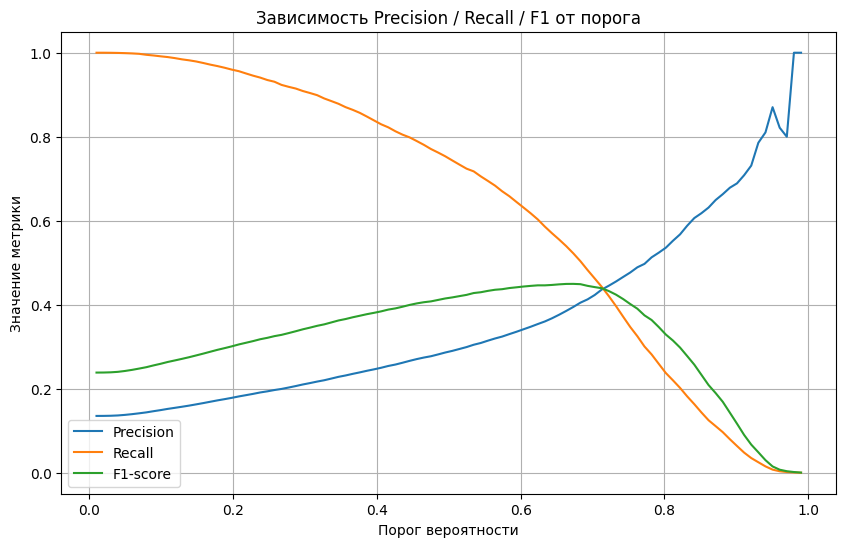

In [20]:
plot_precision_recall_curve(y_val, y_val_proba)

###### Считаю наилучшим трешхолдом = 0.85, тк важнее немного пожертвовать precision, чтобы вырос recall, и при этом доля false positive решений не была заоблачной

### === Оценка качества на тесте с подходящим трешхолдом ===

In [21]:
test_proba = model_best.predict_proba(X_test)[:, 1]
y_test_true = y_test.values  # если y_test — Series

#ставлю порог, оцененный по графику
y_test_pred = (test_proba >= 0.85).astype(int)

test_precision = precision_score(y_test_true, y_test_pred, zero_division=0)
test_recall = recall_score(y_test_true, y_test_pred)
test_auc = roc_auc_score(y_test_true, test_proba)
cm = confusion_matrix(y_test_true, y_test_pred)

print(f"\nРезультаты на тесте (threshold = {0.85:.2f}):")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"ROC AUC:   {test_auc:.4f}")
print("Confusion matrix:")
print(cm)


Результаты на тесте (threshold = 0.85):
Precision: 0.6276
Recall:    0.1678
ROC AUC:   0.8159
Confusion matrix:
[[39003   543]
 [ 4539   915]]


In [22]:
def flow_cut(y_prob, threshold):
    return (y_prob >= threshold).mean()

In [30]:
print(f"Flow cut with best threshold: {flow_cut(test_proba, 0.85):.4f}")

Flow cut with best threshold: 0.0324


### Метрики,если срез в 4%

In [32]:
def get_threshold_for_top_percent(y_proba, top_percent=0.04):
    k = int(len(y_proba) * top_percent)
    sorted_proba = np.sort(y_proba)
    return sorted_proba[-k]

In [29]:
threshold_4pct = get_threshold_for_top_percent(test_proba, top_percent=0.04)
y_pred_top4 = (test_proba >= threshold_4pct).astype(int)

#метрики в этом срезе:
precision = precision_score(y_test_true, y_pred_top4)
recall = recall_score(y_test_true, y_pred_top4)
stream_cut = (y_pred_top4 == 1).mean()

print(f"Threshold @ top 4%: {threshold_4pct:.4f}")
print(f"Precision@4%: {precision:.4f}")
print(f"Recall@4%:    {recall:.4f}")
print(f"Отсечено:     {stream_cut*100:.2f}% заявок")

Threshold @ top 4%: 0.8328
Precision@4%: 0.5956
Recall@4%:    0.1966
Отсечено:     4.00% заявок


### === Важность фичей ===

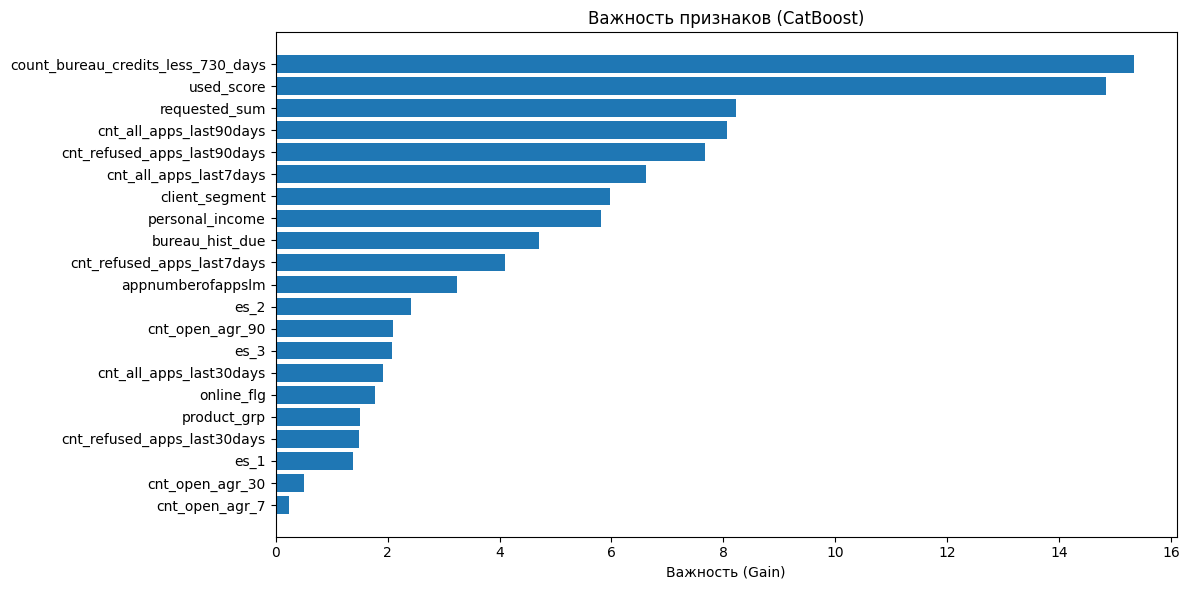

                           Feature Id  Importances
0  count_bureau_credits_less_730_days    15.327035
1                          used_score    14.825898
2                       requested_sum     8.232297
3             cnt_all_apps_last90days     8.065857
4         cnt_refused_apps_last90days     7.668686
5              cnt_all_apps_last7days     6.622942
6                      client_segment     5.978991
7                     personal_income     5.818032
8                     bureau_hist_due     4.705667
9          cnt_refused_apps_last7days     4.094488


In [34]:
importances = model_best.get_feature_importance(prettified=True)

importances_sorted = importances.sort_values(by="Importances", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importances_sorted["Feature Id"], importances_sorted["Importances"])
plt.xlabel("Важность (Gain)")
plt.title("Важность признаков (CatBoost)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#топ-10
print(importances_sorted.head(10))